# Imports

In [1]:
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

# Data Processing

In [2]:
df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
# Count of Attrition categories
attrition_counts = df['Attrition'].value_counts()
print("Attrition Distribution:\n", attrition_counts)


Attrition Distribution:
 Attrition
No     1233
Yes     237
Name: count, dtype: int64


## Correlation Heatmap

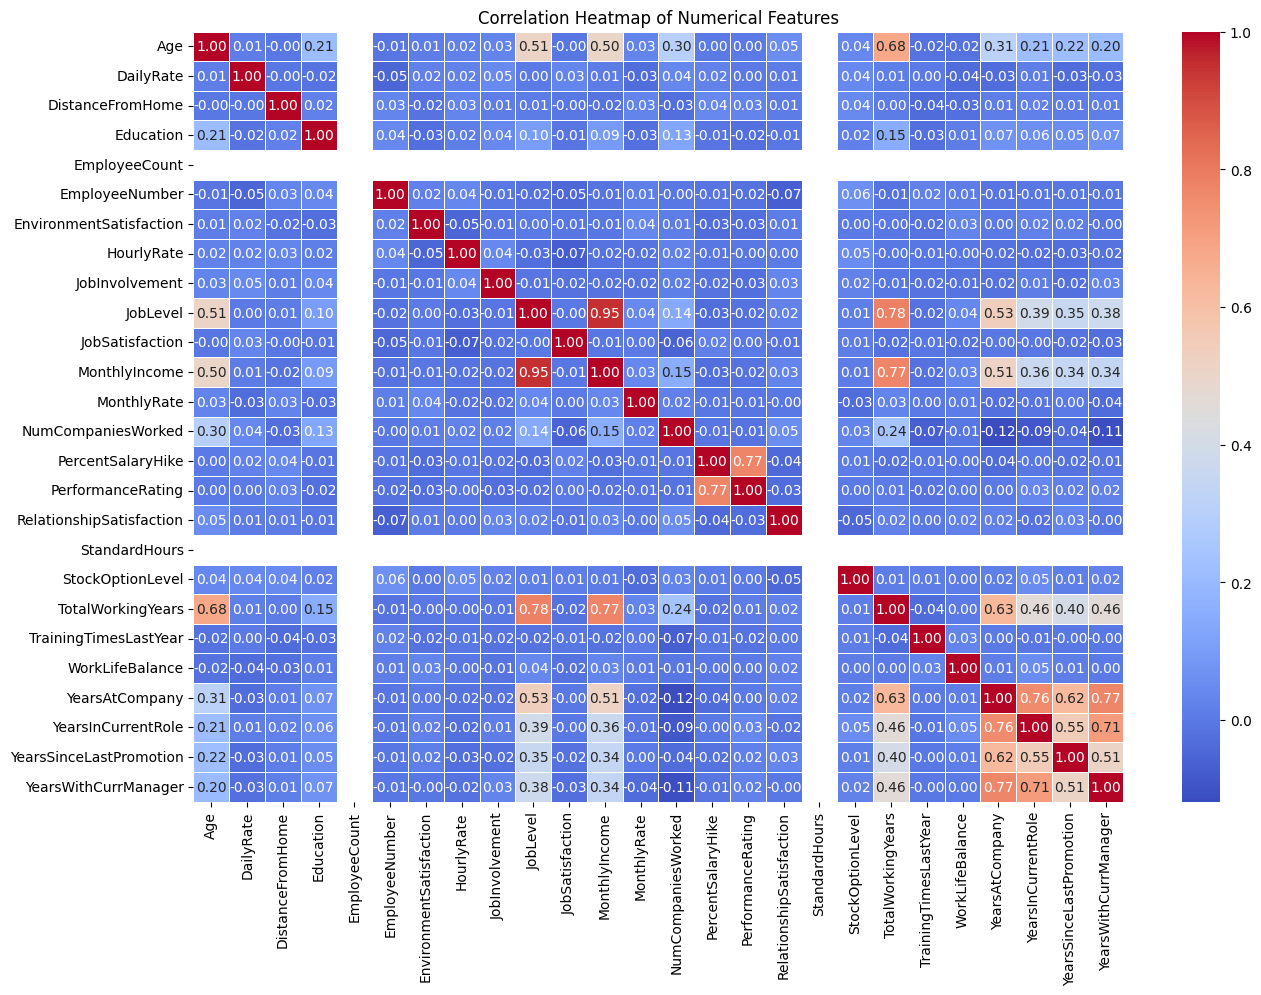

In [3]:
# Correlation heatmap
plt.figure(figsize=(15, 10))
numeric_df = df.select_dtypes(include='number')
corr_matrix = numeric_df.corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


In [4]:
df = df.drop(["JobLevel","PerformanceRating","EmployeeNumber","EmployeeCount","StandardHours","PercentSalaryHike","MonthlyIncome","Over18","YearsWithCurrManager","YearsInCurrentRole","YearsSinceLastPromotion"],axis="columns")

In [5]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,Single,19479,8,Yes,1,0,8,0,1,6
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,Married,24907,1,No,4,1,10,3,3,10
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,Single,2396,6,Yes,2,0,7,3,3,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,Married,23159,1,Yes,3,0,8,3,3,8
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,Married,16632,9,No,4,1,6,3,3,2


## Label Encoding

In [6]:
String_df = df.select_dtypes(include='object')
col_to_encode=String_df.columns

In [7]:
encoders = {}

for col in col_to_encode:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    encoders[col] = le

In [8]:
# Saving the encoder models
model_save_dir = 'encoder_models'
os.makedirs(model_save_dir, exist_ok=True)

for col_name, encoder_model in encoders.items():
    encoders_filename = os.path.join(model_save_dir, f'{col_name}_encoder.pkl')
    with open(encoders_filename, 'wb') as file:
        pickle.dump(encoder_model, file)

In [9]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,41,1,2,1102,2,1,2,1,2,0,...,2,19479,8,1,1,0,8,0,1,6
1,49,0,1,279,1,8,1,1,3,1,...,1,24907,1,0,4,1,10,3,3,10
2,37,1,2,1373,1,2,2,4,4,1,...,2,2396,6,1,2,0,7,3,3,0
3,33,0,1,1392,1,3,4,1,4,0,...,1,23159,1,1,3,0,8,3,3,8
4,27,0,2,591,1,2,1,3,1,1,...,1,16632,9,0,4,1,6,3,3,2


In [10]:
df.describe()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,0.161224,1.607483,802.485714,1.260544,9.192517,2.912925,2.247619,2.721769,0.600000,...,1.097279,14313.103401,2.693197,0.282993,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163
std,9.135373,0.367863,0.665455,403.509100,0.527792,8.106864,1.024165,1.331369,1.093082,0.490065,...,0.730121,7117.786044,2.498009,0.450606,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525
min,18.000000,0.000000,0.000000,102.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,0.000000,2094.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,30.000000,0.000000,1.000000,465.000000,1.000000,2.000000,2.000000,1.000000,2.000000,0.000000,...,1.000000,8047.000000,1.000000,0.000000,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000
50%,36.000000,0.000000,2.000000,802.000000,1.000000,7.000000,3.000000,2.000000,3.000000,1.000000,...,1.000000,14235.500000,2.000000,0.000000,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000
75%,43.000000,0.000000,2.000000,1157.000000,2.000000,14.000000,4.000000,3.000000,4.000000,1.000000,...,2.000000,20461.500000,4.000000,1.000000,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000
max,60.000000,1.000000,2.000000,1499.000000,2.000000,29.000000,5.000000,5.000000,4.000000,1.000000,...,2.000000,26999.000000,9.000000,1.000000,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000


## Scaling

In [11]:
col_to_scale = ["Age","DailyRate","DistanceFromHome","HourlyRate","MonthlyRate","TotalWorkingYears","YearsAtCompany"]
scaler = StandardScaler()
df[col_to_scale] = scaler.fit_transform(df[col_to_scale])
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,MaritalStatus,MonthlyRate,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany
0,0.446350,1,2,0.742527,2,-1.010909,2,1,2,0,...,2,0.726020,8,1,1,0,-0.421642,0,1,-0.164613
1,1.322365,0,1,-1.297775,1,-0.147150,1,1,3,1,...,1,1.488876,1,0,4,1,-0.164511,3,3,0.488508
2,0.008343,1,2,1.414363,1,-0.887515,2,4,4,1,...,2,-1.674841,6,1,2,0,-0.550208,3,3,-1.144294
3,-0.429664,0,1,1.461466,1,-0.764121,4,1,4,0,...,1,1.243211,1,1,3,0,-0.421642,3,3,0.161947
4,-1.086676,0,2,-0.524295,1,-0.887515,1,3,1,1,...,1,0.325900,9,0,4,1,-0.678774,3,3,-0.817734


In [12]:
scaler_save_dir = 'scaler_models'
os.makedirs(scaler_save_dir, exist_ok=True)
scaler_filename = os.path.join(scaler_save_dir, 'standard_scaler.pkl')

with open(scaler_filename, 'wb') as file:
    pickle.dump(scaler, file)

# Data Splitting

## Applying SMOTE to balance data

In [13]:
X = df.drop("Attrition",axis="columns")
y = df["Attrition"]
sm = SMOTE(random_state=42)
X,y = sm.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)


In [15]:
attrition_counts = y.value_counts()
print("Attrition Distribution:\n", attrition_counts)

Attrition Distribution:
 Attrition
1    1233
0    1233
Name: count, dtype: int64


# Model Building

In [16]:
def Eval(model, name):
    y_pred = model.predict(X_test)

    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=['1', '0']))

    print(f"\nConfusion Matrix for {name}:")
    print(confusion_matrix(y_test, y_pred))

    print(f"\nAccuracy Score for {name}:")
    print(accuracy_score(y_test, y_pred))

## Logistic Regression

In [17]:
lg = LogisticRegression(class_weight="balanced")
lg.fit(X_train,y_train)
Eval(lg, "Logistic Regression")

Classification Report for Logistic Regression:
              precision    recall  f1-score   support

           1       0.79      0.80      0.79       369
           0       0.80      0.79      0.79       371

    accuracy                           0.79       740
   macro avg       0.79      0.79      0.79       740
weighted avg       0.79      0.79      0.79       740


Confusion Matrix for Logistic Regression:
[[294  75]
 [ 78 293]]

Accuracy Score for Logistic Regression:
0.7932432432432432


## RandomForest Classifier

In [18]:
rf = RandomForestClassifier(n_estimators=50,class_weight="balanced")
rf.fit(X_train,y_train)
Eval(rf, "Random Forest Classifier")

Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           1       0.88      0.92      0.90       369
           0       0.92      0.88      0.90       371

    accuracy                           0.90       740
   macro avg       0.90      0.90      0.90       740
weighted avg       0.90      0.90      0.90       740


Confusion Matrix for Random Forest Classifier:
[[339  30]
 [ 45 326]]

Accuracy Score for Random Forest Classifier:
0.8986486486486487


## XGBoost

In [19]:
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()

scale_pos_weight_value = neg_count / pos_count
xg = XGBClassifier(objective='multi:softmax', num_class=2, eval_metric='mlogloss',scale_pos_weight=scale_pos_weight_value)
xg.fit(X_train,y_train)
Eval(xg, "XGBoost")

Classification Report for XGBoost:
              precision    recall  f1-score   support

           1       0.92      0.94      0.93       369
           0       0.94      0.92      0.93       371

    accuracy                           0.93       740
   macro avg       0.93      0.93      0.93       740
weighted avg       0.93      0.93      0.93       740


Confusion Matrix for XGBoost:
[[347  22]
 [ 29 342]]

Accuracy Score for XGBoost:
0.9310810810810811


D:\Miniconda3\envs\pytorch_env\lib\site-packages\xgboost\training.py:183: UserWarning: [13:21:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Model Selection Summary
For the task of predicting employee attrition, we explored multiple models including Logistic Regression, Random Forest, and XGBoost. After initial evaluation, we selected Random Forest and XGBoost for further tuning and final deployment.

✅ Why Random Forest?
Random Forest performed exceptionally well on the majority class (employees staying).

It had the highest accuracy (89%) among all models.

Although it struggled with minority class (attrition), it has support for handling imbalanced datasets via class_weight='balanced'.

It's interpretable, robust, and relatively fast to train, making it a strong baseline.

✅ Why XGBoost?
XGBoost is known to perform extremely well on structured/tabular data.

It allows fine-grained control over imbalanced classification using the scale_pos_weight parameter.

It supports regularization and early stopping, which helps prevent overfitting.

In industry settings, XGBoost is widely adopted for classification problems like this and provides better handling of difficult cases when tuned properly.

# Hyperparameter Tuning

## Random Forest (Tuned)

In [20]:
param_grid_rf = {
    'n_estimators': [50,100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=42)

grid_rf = GridSearchCV(estimator=rf, param_grid=param_grid_rf,
                       cv=5, scoring='f1', n_jobs=-1, verbose=2)

grid_rf.fit(X_train, y_train)

# Evaluation
best_rf = grid_rf.best_estimator_
Eval(best_rf, "Random Forest (Tuned)")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Classification Report for Random Forest (Tuned):
              precision    recall  f1-score   support

           1       0.89      0.93      0.91       369
           0       0.93      0.89      0.91       371

    accuracy                           0.91       740
   macro avg       0.91      0.91      0.91       740
weighted avg       0.91      0.91      0.91       740


Confusion Matrix for Random Forest (Tuned):
[[345  24]
 [ 41 330]]

Accuracy Score for Random Forest (Tuned):
0.9121621621621622


## XGBoost (Tuned)

In [22]:
# Fix for scale_pos_weight
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale_pos_weight_value = neg_count / pos_count

param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [scale_pos_weight_value],  # fixed value from imbalance
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

xgb = XGBClassifier(objective='binary:logistic', eval_metric='logloss', random_state=42)

grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb,
                        cv=5, scoring='f1', n_jobs=-1, verbose=2)

grid_xgb.fit(X_train, y_train)

# Evaluation
best_xgb = grid_xgb.best_estimator_
Eval(best_xgb, "XGBoost (Tuned)")

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Classification Report for XGBoost (Tuned):
              precision    recall  f1-score   support

           1       0.92      0.93      0.92       369
           0       0.93      0.91      0.92       371

    accuracy                           0.92       740
   macro avg       0.92      0.92      0.92       740
weighted avg       0.92      0.92      0.92       740


Confusion Matrix for XGBoost (Tuned):
[[345  24]
 [ 32 339]]

Accuracy Score for XGBoost (Tuned):
0.9243243243243243


## Conclusion

### ✅ Final Model Selection
### 🔍 Comparison:
Metric	Random Forest	XGBoost <br>
Accuracy	91.2%	92.4% ✅ <br>
F1-score (avg)	0.91	0.92 ✅ <br>
Recall (class 0)	0.89	0.91 ✅ <br>
Confusion Matrix	Slightly more false negatives	Fewer false negatives ✅ <br>

### ✅ Selected Final Model: XGBoost (Tuned)
It slightly outperforms Random Forest across almost all metrics — especially for minority class (attrition = Yes).



# Model Export

In [23]:
with open("models/main_model/xgboost_model.pkl", "wb") as f:
    pickle.dump(best_xgb, f)